In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sys
sys.setrecursionlimit(10000)
file_path="/home/khaldi/Downloads/classic3.csv"
text_col="text"
label_col="label"
text_col_cleaned=text_col + "_cleaned"
repr_names=["Word2vec", "GloVe"]
reduc_names=["PCA","TSNE","UMAP","AE","Original"]
glove_path="/home/khaldi/modeles_word2vec/glove.42B.300d_glove.txt"
cluster_methods={"Kmeans","SphericalKmeans","CAH ward","CAH single","CAH complete"}
d=300

In [2]:
df=pd.read_csv(file_path)
df=df.drop(["Unnamed: 0"],axis=1)

In [3]:
labels=df[label_col]

In [4]:
labels.unique() #number of True class:3

array(['cisi', 'med', 'cran'], dtype=object)

In [5]:
from src.core.processing.Preprocessing import Preprocessing
def clean(text:str) -> list:
    return Preprocessing.pipeline(text)

In [6]:
df[text_col_cleaned] = df[text_col].apply(lambda text:  " ".join(clean(text)))

In [7]:
repr_dict={repr_name: None for repr_name in repr_names}

In [8]:
for repr_name in repr_dict.keys():
    repr_dict[repr_name]={
        "tools_dict":{tool_name:None for tool_name in {"embeddings","mapping","docs_transformed"}},
        "reduc_dict":{method_reduc:None for method_reduc in reduc_names}
    }

In [9]:
from src.core.processing.Processing import Processing
def create_mapping(texts:pd.Series,min_count=1) -> tuple[list[str],dict[str,int]]:
    docs=list(texts)
    vocab=Processing.create_vocab(Processing.list_words_from_sentences(docs),
                                  min_count=min_count)
    docs_tranformed=[" ".join(list(s)) for s in vocab.lookup([docs[i].split() for i in range(len(docs))])]
    vocab=[word for word in sorted(vocab) if min_count>1 or (word != '<UNK>' and min_count==1) ]
    return docs_tranformed,{word:i for i,word in enumerate(vocab)}


In [10]:
from src.core.embedding.ModelForEmbedding import ModelForEmbedding
def get_embeddings(docs:pd.Series,mapping,
              method="Word2vec",file_out_glove=None):
    model_embed=ModelForEmbedding(list(docs),mapping)
    return model_embed.word_embeddings(method=method,file_out=file_out_glove,
                         vector_size=d,min_count=1)

In [11]:
docs_transformed,mapping_w=create_mapping(df[text_col_cleaned])

In [12]:
def doc_transformed(i,vocab,docs):
    return " ".join([str(s) for s in docs[i].split() if str(s) in vocab.keys()])

In [13]:
import numpy as np
for repr_name in repr_names:
    t=get_embeddings(docs_transformed,mapping=mapping_w,
                     method=repr_name,file_out_glove=glove_path)
    words_embed:dict[str,np.ndarray]=t[0]
    vocab:dict[str,int]=t[1]
    repr_dict[repr_name]["tools_dict"]["mapping"]=vocab
    repr_dict[repr_name]["tools_dict"]["docs_transformed"]=[doc_transformed(i,vocab,docs_transformed)
                                                             for i in range(len(docs_transformed))]
    repr_dict[repr_name]["tools_dict"]["embeddings"]=words_embed

In [14]:
from src.core.reduction.ReductionEmbedding import ReductionEmbedding
from src.core.embedding.SentenceEmbedding import SentencesEmbedding
from src.core.globals import DEFAULT_PARAMS
import numpy as np


for repr_name in repr_names:
    embeddings_words=np.zeros((len(mapping_w.keys()),d))
    mapping_words=repr_dict[repr_name]["tools_dict"]["mapping"]
    for w in mapping_words.keys():
        embeddings_words[mapping_words[w],:]=repr_dict[repr_name]["tools_dict"]["embeddings"][w]
    embeddings_sentences=SentencesEmbedding(embeddings=embeddings_words,
                                           mapping=mapping_words)\
                        .create_sentences_embedding(repr_dict[repr_name]["tools_dict"]["docs_transformed"])

    repr_dict[repr_name]["reduc_dict"]={
                                        reduc_name:{
                                            "X_reduced":ReductionEmbedding(embeddings_sentences) \
                                                .create_reduced_matrix(method=reduc_name,
                                                                       params=DEFAULT_PARAMS[reduc_name]),
                                            "cluster_methods":{
                                                cluster_method:{
                                                    "labels":None,
                                                    "pmi":None,
                                                    "ari": None
                                                }
                                                for cluster_method in cluster_methods
                                            }
                                        }
                                        for reduc_name in reduc_names if reduc_name != "Original"
                                        }
    repr_dict[repr_name]["reduc_dict"]["Original"]={
        "X_reduced":embeddings_sentences,
        "cluster_methods":{
            cluster_method:{
                "labels":None,
                "pmi":None,
                "ari":None
            }
            for cluster_method in cluster_methods
        }
    }

/home/khaldi/.cache/pypoetry/virtualenvs/cluster-reduc-data2-0RuPNS-h-py3.10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/khaldi/.cache/pypoetry/virtualenvs/cluster-reduc-data2-0RuPNS-h-py3.10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 

Word2vec Embeddings
Dimensionality Reduction
Pourcentage de variance des deux premières axes [0.00036791 0.00011419]


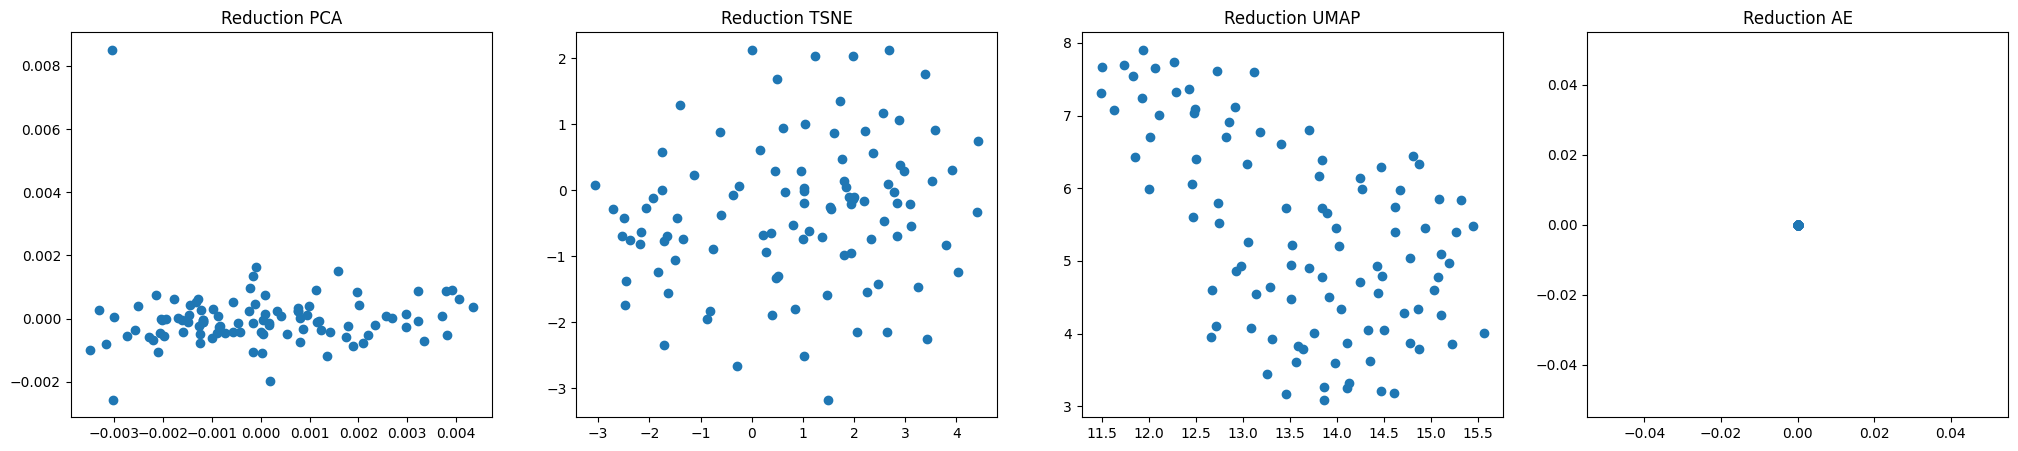

In [18]:
import matplotlib.pyplot as plt
fig,axs=plt.subplots(nrows=1,ncols=4,figsize=(5*5,5))
repr_name="Word2vec"
print(f"{repr_name} Embeddings")
print("Dimensionality Reduction")
for i in range(len(reduc_names)):
    if reduc_names[i] != "Original":
        X_reduced=repr_dict[repr_name]["reduc_dict"][reduc_names[i]]["X_reduced"]
        axs[i].scatter(X_reduced[:,0],X_reduced[:,1])
        axs[i].set_title(f"Reduction {reduc_names[i]}")


GloVe Embeddings
Dimensionality Reduction
Pourcentage de variance des deux premières axes [53.9320799 32.9944446]


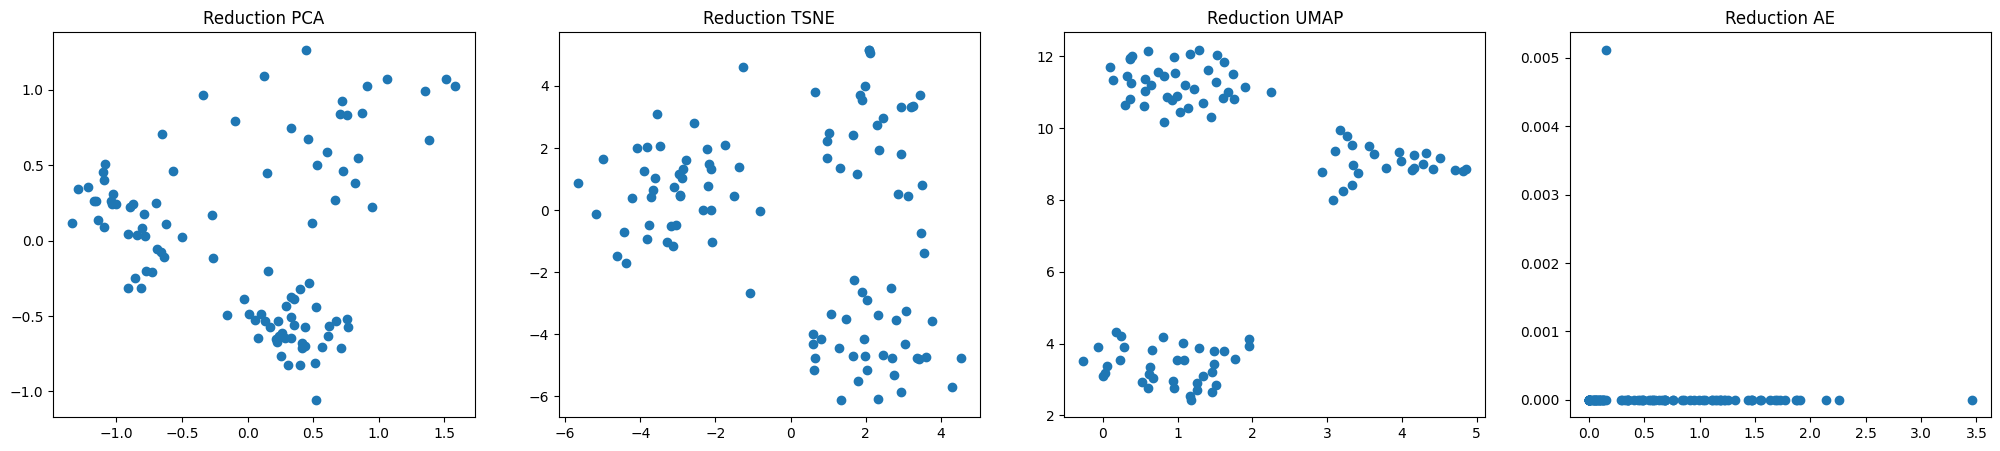

In [19]:
import matplotlib.pyplot as plt
fig,axs=plt.subplots(nrows=1,ncols=4,figsize=(5*5,5))
repr_name="GloVe"
print(f"{repr_name} Embeddings")
print("Dimensionality Reduction")
for i in range(len(reduc_names)):
    if reduc_names[i] != "Original":
        X_reduced=repr_dict[repr_name]["reduc_dict"][reduc_names[i]]["X_reduced"]
        axs[i].scatter(X_reduced[:,0],X_reduced[:,1])
        axs[i].set_title(f"Reduction {reduc_names[i]}")

In [17]:
from src.core.clustering.SphericalKmeans import SphericalKmeans
from src.core.clustering.KMeans import Kmeans
from src.core.clustering.CAH import CAH
from sklearn.metrics import normalized_mutual_info_score as nmi

In [18]:
PARAMS={
    "Kmeans":{
        "n_clusters":3,
        "init":"k-means++",
        "n_init":"auto",
        "max_iter":300,
        "tol":1e-4,
        "verbose":0,
        "random_state":None,
        "copy_x":True,
        "algorithm":"lloyd"
    },
    "SphericalKmeans":{
        "n_clusters":3,
        "init":"k-means++",
        "n_init":"auto",
        "max_iter":300,
        "tol":1e-4,
        "verbose":0,
        "random_state":None,
        "copy_x":True,
        "algorithm":"lloyd"
    },
    "CAH": {
        "method":None,
    }
}

In [19]:
def get(repr_name,reduc_name):
    return repr_dict[repr_name]["reduc_dict"][reduc_name]

Word2vec Embeddings


/home/khaldi/.cache/pypoetry/virtualenvs/cluster-reduc-data2-0RuPNS-h-py3.10/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:2843: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])
/home/khaldi/.cache/pypoetry/virtualenvs/cluster-reduc-data2-0RuPNS-h-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/khaldi/.cache/pypoetry/virtualenvs/cluster-reduc-data2-0RuPNS-h-py3.10/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:2843: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])
/home/khaldi/.cache/pypoetry/virtualenvs/cluster-reduc-data2-0RuPNS-h-py3.10/lib/python3.10/site-packages/sklearn/clust

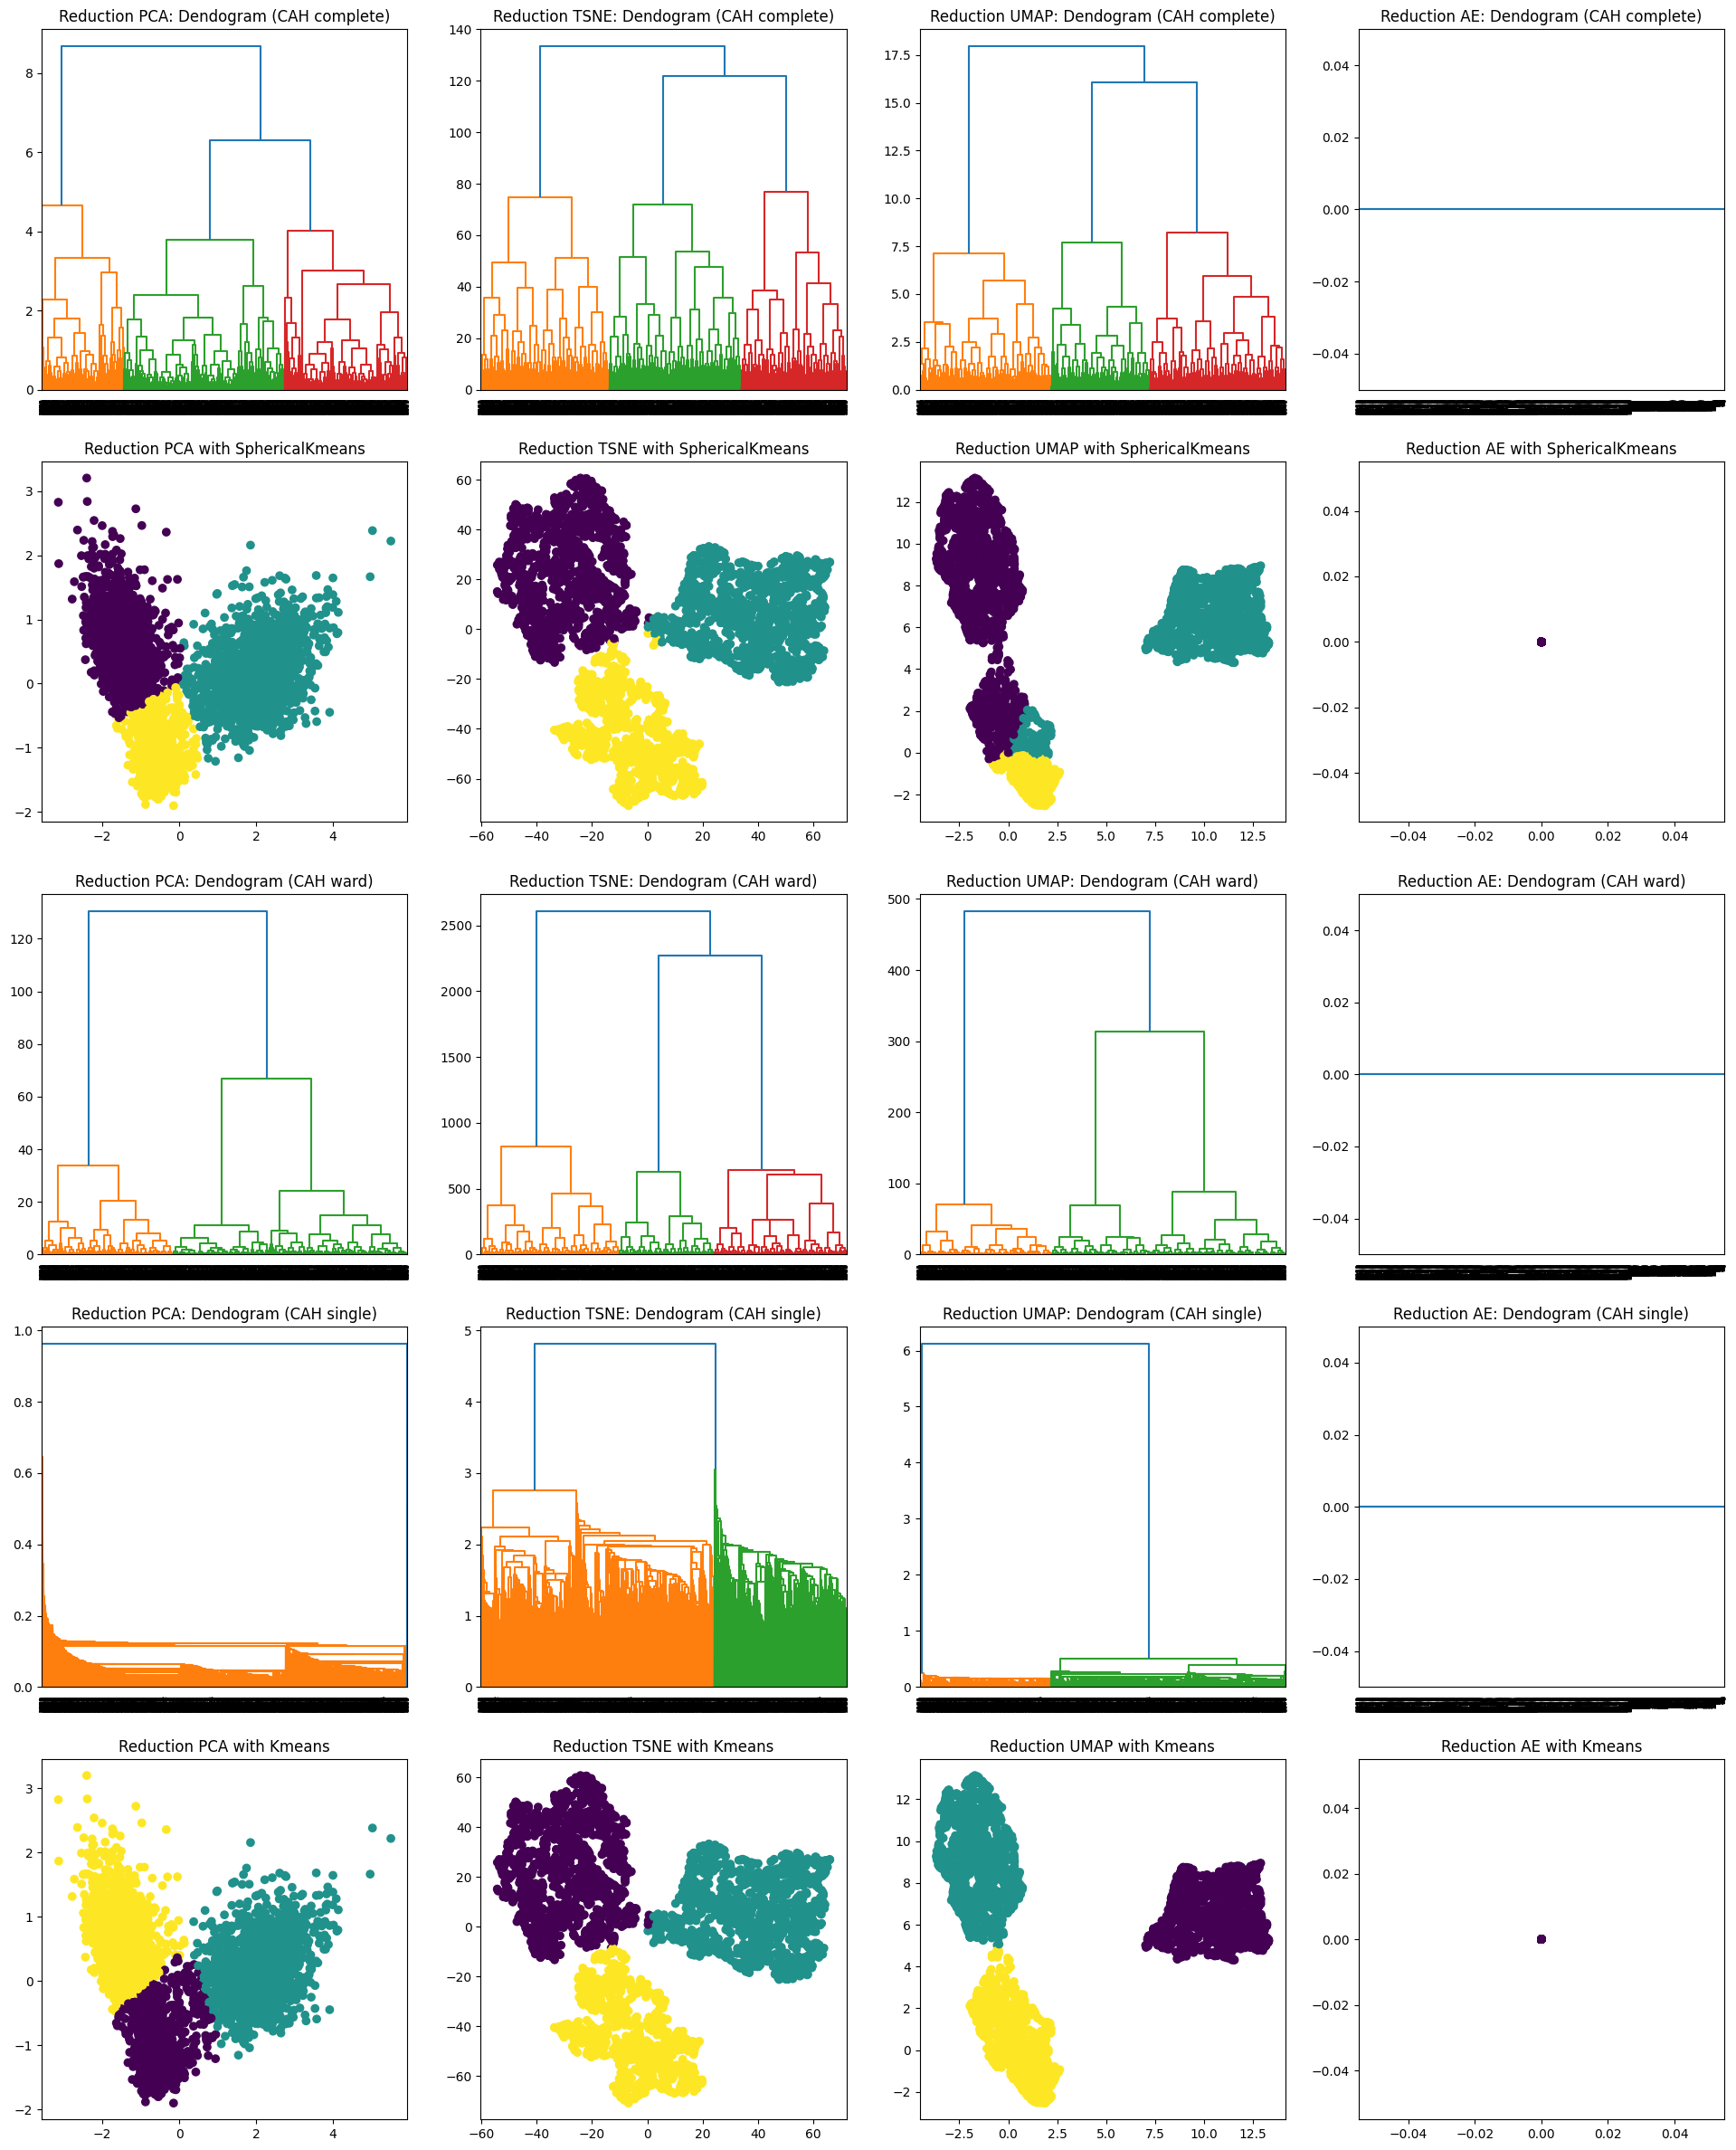

In [23]:
import matplotlib.pyplot as plt
fig,axs=plt.subplots(nrows=5,ncols=4,figsize=(4*6,5*6))
repr_name="Word2vec"
print(f"{repr_name} Embeddings")

for i in range(len(reduc_names)):
    reduc_name=reduc_names[i]
    try:
        X_reduced=repr_dict[repr_name]["reduc_dict"][reduc_name]["X_reduced"]
        k=0
        for cluster_method in cluster_methods:
            if cluster_method.split()[0] == "CAH":
                PARAMS[cluster_method.split()[0]]["method"]=cluster_method.split()[1]
                cah=CAH(hyperparams=PARAMS[cluster_method.split()[0]])
                repr_dict[repr_name]["reduc_dict"][reduc_name]["cluster_methods"] \
                    [cluster_method]["model"]=cah
                if reduc_name != "Original":
                    cah.create_dendogram(X_reduced,ax=axs[k,i])
                    axs[k,i].set_title(f"Reduction {reduc_name}: Dendogram ({cluster_method})")
                    k+=1
            else:
                repr_dict[repr_name]["reduc_dict"][reduc_name]["cluster_methods"] \
                    [cluster_method]["model"]=globals()[cluster_method](hyperparams=PARAMS[cluster_method])
                labels_model=repr_dict[repr_name]["reduc_dict"][reduc_name]["cluster_methods"] \
                    [cluster_method]["model"].fit_predict(X_reduced)
                if reduc_name != "Original":
                    axs[k,i].scatter(X_reduced[:,0],X_reduced[:,1],c=labels_model)
                    axs[k,i].set_title(f"Reduction {reduc_name} with {cluster_method}")
                    k+=1
                repr_dict[repr_name]["reduc_dict"][reduc_name]["cluster_methods"][cluster_method]["labels"]=labels_model
    except ValueError as e:
        print(e)

In [24]:
import pandas as pd
repr_name="Word2vec"
print(f"{repr_name} Embeddings")
for i in range(len(reduc_names)):
    reduc_name=reduc_names[i]
    for cluster_method in cluster_methods:
        X_reduced=get(repr_name,reduc_name)["X_reduced"]
        get(repr_name,reduc_name)["cluster_methods"][cluster_method]["pmi"]= \
            get(repr_name,reduc_name)["cluster_methods"] \
                [cluster_method]["model"].get_pmi(labels_true=labels,X=X_reduced)

Word2vec Embeddings


/home/khaldi/.cache/pypoetry/virtualenvs/cluster-reduc-data2-0RuPNS-h-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/khaldi/.cache/pypoetry/virtualenvs/cluster-reduc-data2-0RuPNS-h-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


In [31]:
import pandas as pd
repr_name="Word2vec"
print(f"{repr_name} Embeddings")
for i in range(len(reduc_names)):
    reduc_name=reduc_names[i]
    for cluster_method in cluster_methods:
        X_reduced=get(repr_name,reduc_name)["X_reduced"]
        get(repr_name,reduc_name)["cluster_methods"][cluster_method]["ari"]= \
            get(repr_name,reduc_name)["cluster_methods"] \
                [cluster_method]["model"].get_ari(labels_true=labels,X=X_reduced)

Word2vec Embeddings


/home/khaldi/.cache/pypoetry/virtualenvs/cluster-reduc-data2-0RuPNS-h-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/khaldi/.cache/pypoetry/virtualenvs/cluster-reduc-data2-0RuPNS-h-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


In [32]:
df_pmi_w2vec=pd.DataFrame()
for i in range(len(reduc_names)):
    df_pmi_w2vec[reduc_names[i]]=pd.Series([get(repr_name,reduc_names[i])["cluster_methods"][cluster_method]["pmi"] \
                                      for cluster_method in cluster_methods])
df_pmi_w2vec = df_pmi_w2vec.set_index(pd.Index(cluster_methods))
print(f"{repr_name} Embeddings: PMI")
df_pmi_w2vec

Word2vec Embeddings: PMI


,PCA,TSNE,UMAP,AE,Original
CAH complete,0.649297,0.277234,0.495646,0.0,0.549858
SphericalKmeans,0.857991,0.870934,0.639331,0.0,0.883101
CAH ward,0.421139,0.271882,0.359439,0.0,0.379271
CAH single,0.000000,0.687448,0.690954,0.0,0.000000
Kmeans,0.796944,0.873253,0.867004,0.0,0.797881


In [35]:
df_ari_w2vec=pd.DataFrame()
for i in range(len(reduc_names)):
    df_ari_w2vec[reduc_names[i]]=pd.Series([get(repr_name,reduc_names[i])["cluster_methods"][cluster_method]["ari"] \
                                      for cluster_method in cluster_methods])
print(f"{repr_name} Embeddings: ARI")
df_ari_w2vec = df_ari_w2vec.set_index(pd.Index(cluster_methods))
df_ari_w2vec

Word2vec Embeddings: ARI


,PCA,TSNE,UMAP,AE,Original
CAH complete,0.569989,0.005139,0.206804,0.0,0.359087
SphericalKmeans,0.908309,0.918299,0.646322,0.0,0.926751
CAH ward,0.109856,0.004202,0.040182,0.0,0.061660
CAH single,0.000000,0.587268,0.588516,0.0,0.000000
Kmeans,0.838147,0.921271,0.916053,0.0,0.839385


GloVe Embeddings


/home/khaldi/.cache/pypoetry/virtualenvs/cluster-reduc-data2-0RuPNS-h-py3.10/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:2843: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])
/home/khaldi/.cache/pypoetry/virtualenvs/cluster-reduc-data2-0RuPNS-h-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/khaldi/.cache/pypoetry/virtualenvs/cluster-reduc-data2-0RuPNS-h-py3.10/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:2843: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([0, dvw])
/home/khaldi/.cache/pypoetry/virtualenvs/cluster-reduc-data2-0RuPNS-h-py3.10/lib/python3.10/site-packages/sklearn/clust

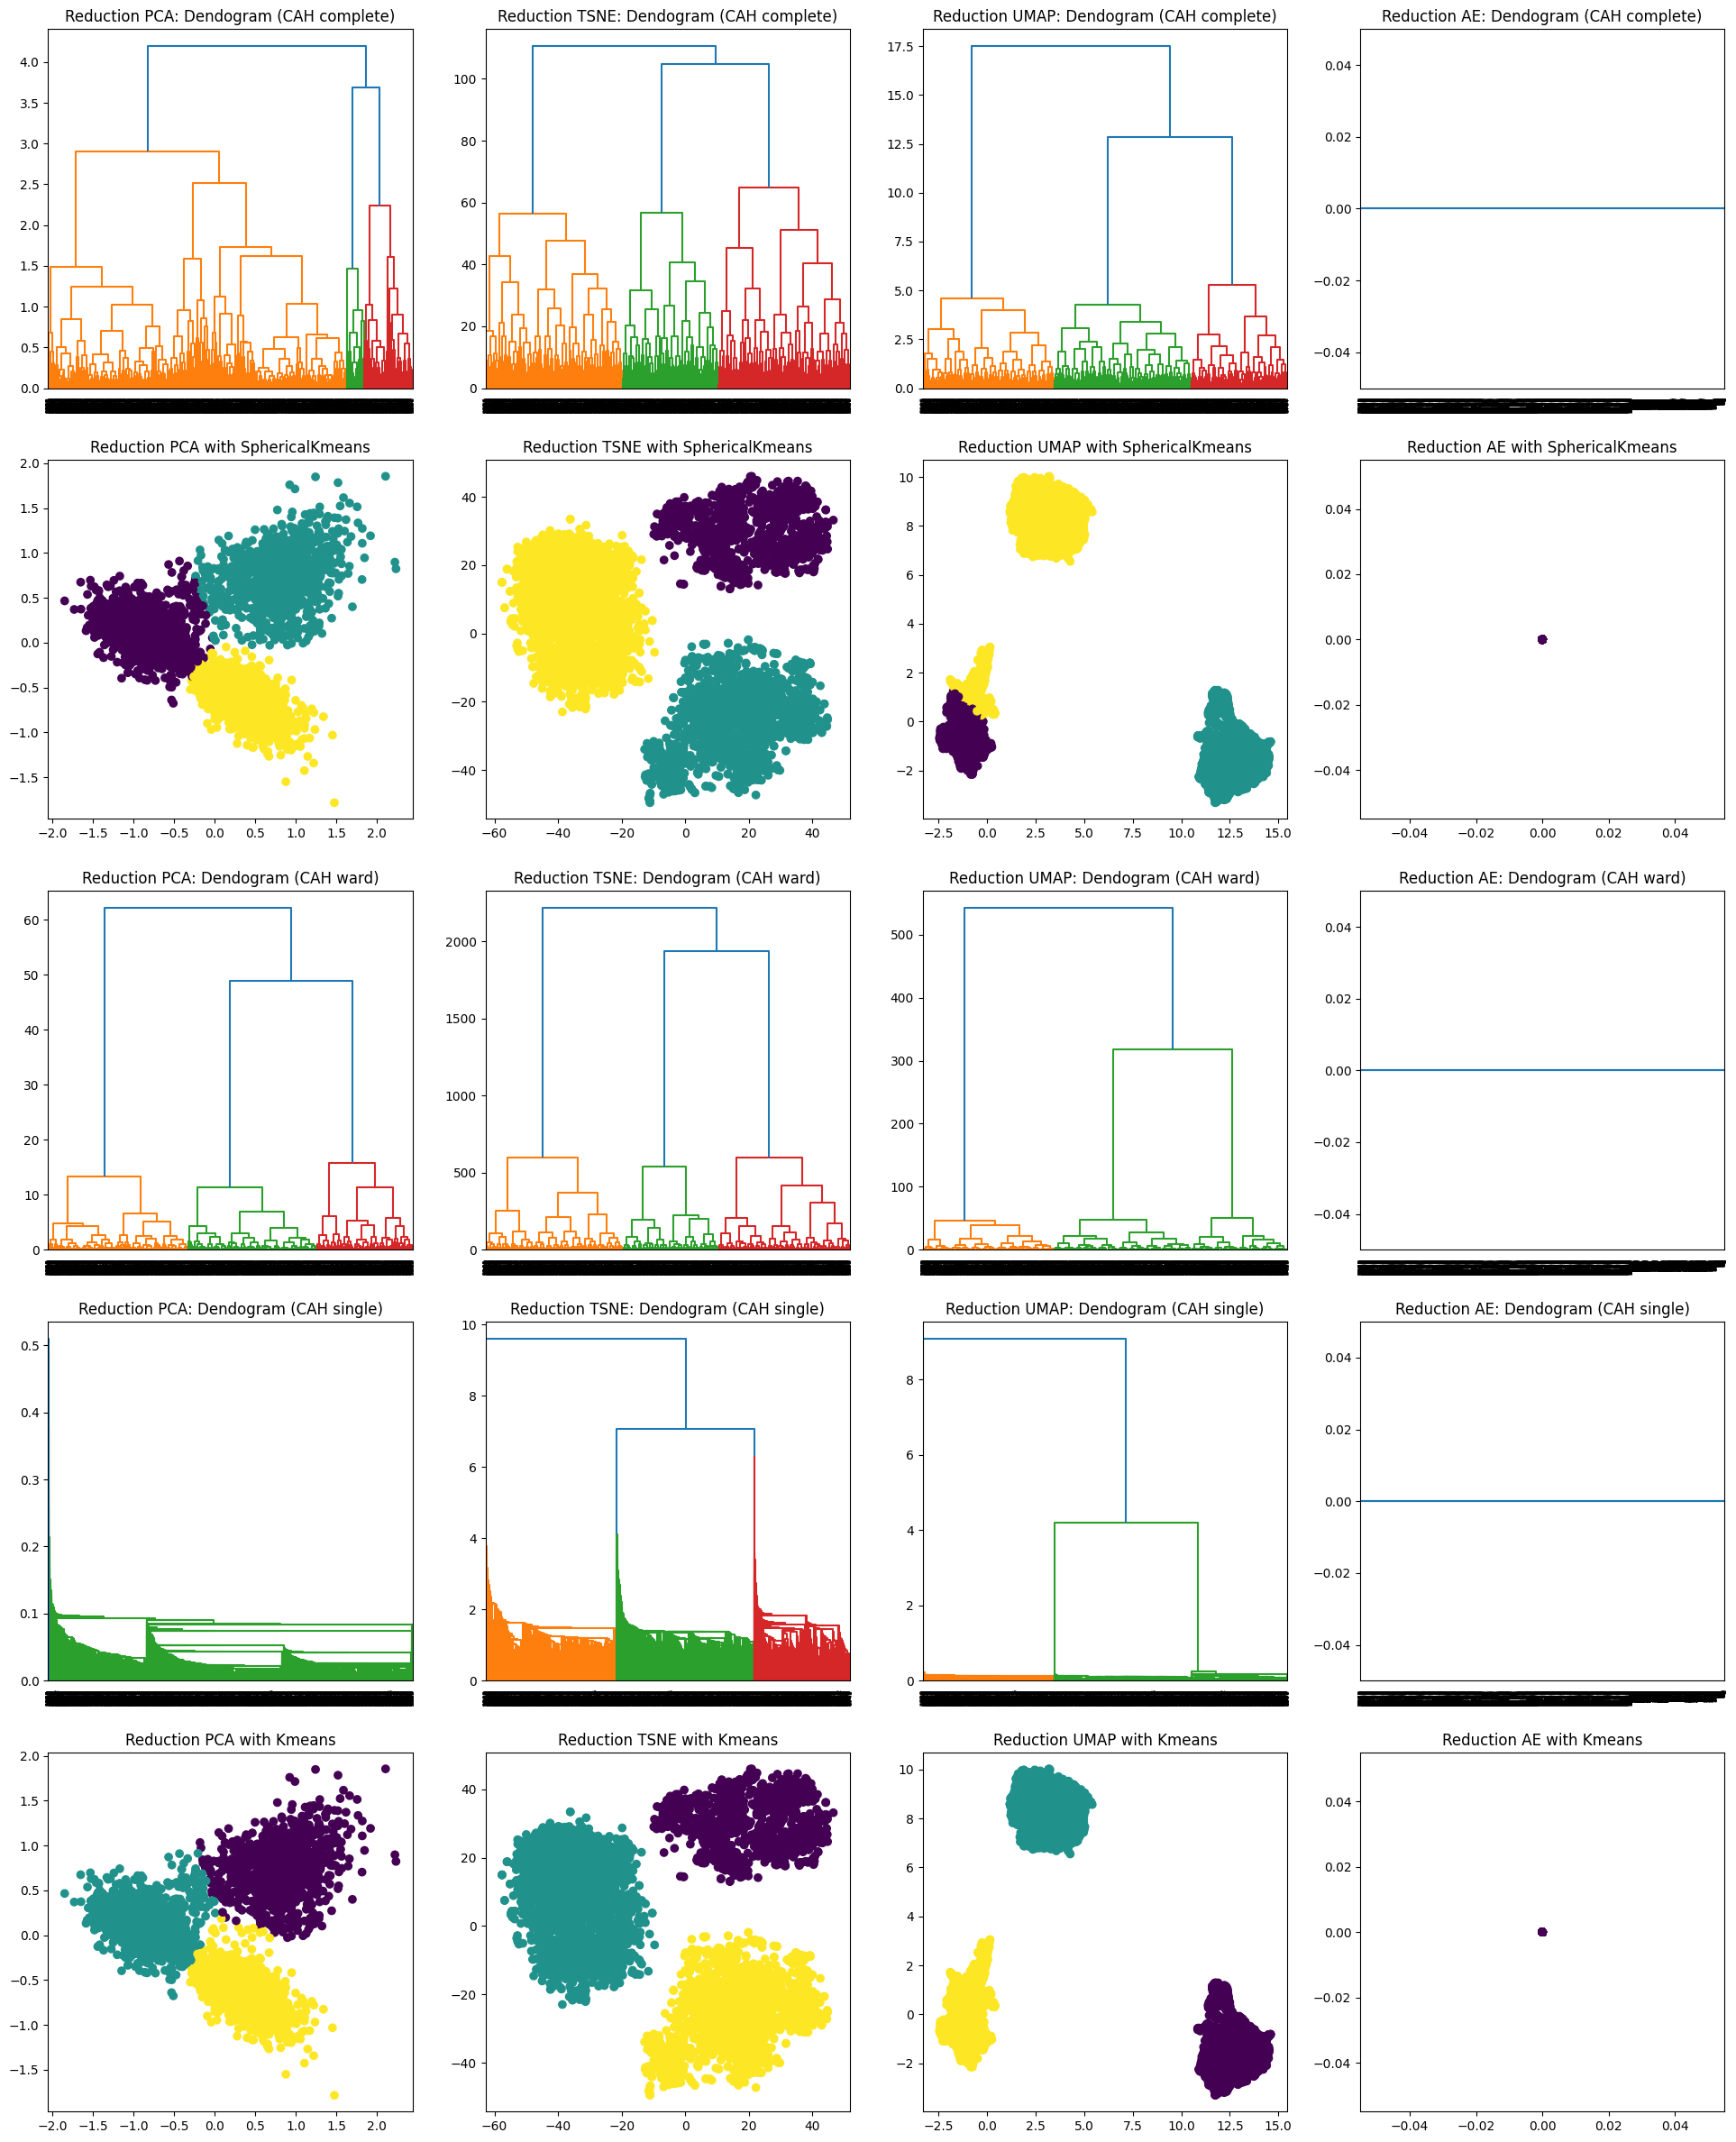

In [36]:
import matplotlib.pyplot as plt
fig,axs=plt.subplots(nrows=5,ncols=4,figsize=(4*6,5*6))
repr_name="GloVe"
print(f"{repr_name} Embeddings")

for i in range(len(reduc_names)):
    reduc_name=reduc_names[i]
    try:
        X_reduced=repr_dict[repr_name]["reduc_dict"][reduc_name]["X_reduced"]
        k=0
        for cluster_method in cluster_methods:
            if cluster_method.split()[0] == "CAH":
                PARAMS[cluster_method.split()[0]]["method"]=cluster_method.split()[1]
                cah=CAH(hyperparams=PARAMS[cluster_method.split()[0]])
                repr_dict[repr_name]["reduc_dict"][reduc_name]["cluster_methods"] \
                    [cluster_method]["model"]=cah
                if reduc_name != "Original":
                    cah.create_dendogram(X_reduced,ax=axs[k,i])
                    axs[k,i].set_title(f"Reduction {reduc_name}: Dendogram ({cluster_method})")
                    k+=1
            else:
                repr_dict[repr_name]["reduc_dict"][reduc_name]["cluster_methods"] \
                    [cluster_method]["model"]=globals()[cluster_method](hyperparams=PARAMS[cluster_method])
                labels_model=repr_dict[repr_name]["reduc_dict"][reduc_name]["cluster_methods"] \
                    [cluster_method]["model"].fit_predict(X_reduced)
                if reduc_name != "Original":
                    axs[k,i].scatter(X_reduced[:,0],X_reduced[:,1],c=labels_model)
                    axs[k,i].set_title(f"Reduction {reduc_name} with {cluster_method}")
                    k+=1
                repr_dict[repr_name]["reduc_dict"][reduc_name]["cluster_methods"][cluster_method]["labels"]=labels_model
    except ValueError as e:
        print(e)

In [37]:
import pandas as pd
repr_name="GloVe"
print(f"{repr_name} Embeddings")
for i in range(len(reduc_names)):
    reduc_name=reduc_names[i]
    for cluster_method in cluster_methods:
        X_reduced=get(repr_name,reduc_name)["X_reduced"]
        get(repr_name,reduc_name)["cluster_methods"][cluster_method]["pmi"]= \
            get(repr_name,reduc_name)["cluster_methods"] \
                [cluster_method]["model"].get_pmi(labels_true=labels,X=X_reduced)

GloVe Embeddings


/home/khaldi/.cache/pypoetry/virtualenvs/cluster-reduc-data2-0RuPNS-h-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/khaldi/.cache/pypoetry/virtualenvs/cluster-reduc-data2-0RuPNS-h-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


In [40]:
for i in range(len(reduc_names)):
    reduc_name=reduc_names[i]
    for cluster_method in cluster_methods:
        X_reduced=get(repr_name,reduc_name)["X_reduced"]
        get(repr_name,reduc_name)["cluster_methods"][cluster_method]["ari"]= \
            get(repr_name,reduc_name)["cluster_methods"] \
                [cluster_method]["model"].get_ari(labels_true=labels,X=X_reduced)

/home/khaldi/.cache/pypoetry/virtualenvs/cluster-reduc-data2-0RuPNS-h-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/home/khaldi/.cache/pypoetry/virtualenvs/cluster-reduc-data2-0RuPNS-h-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1033: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


In [38]:
df_pmi=pd.DataFrame()
for i in range(len(reduc_names)):
    df_pmi[reduc_names[i]]=pd.Series([get(repr_name,reduc_names[i])["cluster_methods"][cluster_method]["pmi"]\
                    for cluster_method in cluster_methods])
print(f"{repr_name} Embeddings: PMI")
df_pmi = df_pmi.set_index(pd.Index(cluster_methods))
df_pmi

GloVe Embeddings: PMI


,PCA,TSNE,UMAP,AE,Original
CAH complete,0.299726,0.288531,0.609785,0.0,0.555275
SphericalKmeans,0.884849,0.955101,0.765801,0.0,0.858235
CAH ward,0.504970,0.279949,0.396296,0.0,0.349000
CAH single,0.000000,0.930711,0.946436,0.0,0.000000
Kmeans,0.857819,0.955101,0.946436,0.0,0.865736


In [41]:
df_ari=pd.DataFrame()
for i in range(len(reduc_names)):
    df_ari[reduc_names[i]]=pd.Series([get(repr_name,reduc_names[i])["cluster_methods"][cluster_method]["ari"] \
                                      for cluster_method in cluster_methods])
print(f"{repr_name} Embeddings: ARI")
df_ari = df_ari.set_index(pd.Index(cluster_methods))
df_ari

GloVe Embeddings: ARI


,PCA,TSNE,UMAP,AE,Original
CAH complete,0.141954,0.006277,0.369670,0.0,0.391974
SphericalKmeans,0.922860,0.976710,0.746950,0.0,0.893488
CAH ward,0.217737,0.004718,0.057889,0.0,0.028939
CAH single,0.000000,0.965622,0.971440,0.0,0.000000
Kmeans,0.900587,0.976710,0.971440,0.0,0.906108
